In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
file = pd.read_csv('model_data.csv')

In [3]:
file = file.fillna(0)

### Preproce

In [4]:
# Manually convert collection_name into nums
collections = {}
count = 1
for col in file['collection_name'].unique():
    collections[col] = count
    count += 1
    
file['collection_name'] = file['collection_name'].apply(lambda x: collections[x])

In [5]:
file['created_at'] = file['created_at'].apply(lambda x: pd.to_datetime(x))

# Let's do some MODELING

<AxesSubplot:>

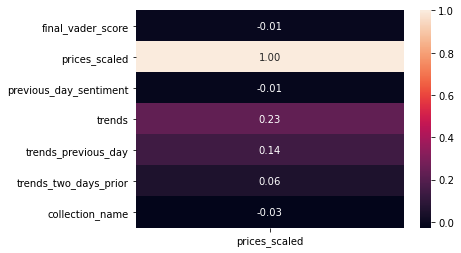

In [6]:
sns.heatmap(file.corr()[['prices_scaled']], annot=True, fmt=".2f")

lol wtf

## Models

Here's what I'm thinking:
- Function which splits the dataframe into many based on the collection_name val
 - That function then calls the train_test_split function which grabs 75 percent of rows for training, appends to a big testing df? Maybe it does it many times? idk
 
so, let's test it on just 1 collection for now

In [7]:
init_df = file[file['collection_name']==1].copy()

In [8]:
init_df.head(1)

,created_at,final_vader_score,prices_scaled,previous_day_sentiment,trends,trends_previous_day,trends_two_days_prior,collection_name
0,2021-09-17,52.2935,5.555677,13.1212,0.17,0.34,0.0,1


In [9]:
(X, y) = (np.array(init_df.drop(columns=['prices_scaled'])), np.array(init_df['prices_scaled']))

In [10]:
file['collection_name'].unique()

array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
       18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34,
       35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51,
       52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68])

In [11]:
# from sklearn.model_selection import train_test_split

# def split_data(data, test_size):
#     (X_temp, y_temp) = (np.array(data.drop(columns=['prices_scaled'])), np.array(data['prices_scaled']))
#     X_train_temp, X_test_temp, y_train_temp, y_test_temp = train_test_split(X_temp, y_temp, test_size=0.2, random_state=699)
#     return(X_train_temp, X_test_temp, y_train_temp, y_test_temp)

# Source: https://medium.com/keita-starts-data-science/time-series-split-with-scikit-learn-74f5be38489e
def split_data(data, test_size):
    X = data.drop(columns=['prices_scaled'])
    y = data['prices_scaled']
    X_train = X[:int(data.shape[0]*(test_size/100))]
    X_test = X[int(data.shape[0]*(test_size/100)):]
    y_train = y[:int(data.shape[0]*(test_size/100))]
    y_test = y[int(data.shape[0]*(test_size/100)):]
    return(X_train, X_test, y_train, y_test)

In [12]:
def create_test_train(df, test_size):
    collection_names = df['collection_name'].unique()
    main_data = split_data(df, test_size)
    X_train = main_data[0]
    X_test = main_data[1]
    y_train = main_data[2]
    y_test = main_data[3]
    
    for collection_name in collection_names[1:]:
        try:
            new_data = split_data(df[df['collection_name']==collection_name], test_size)
            X_train.append(new_data[0])
            X_test.append(new_data[1])
            y_train.append(new_data[2])
            y_test.append(new_data[3])
        except ValueError:
            print("ERROR:")
            for item in collections.items():
                if item[1]==collection_name:
                    print(item)
            pass
#     X_train = np.array(X_train)
#     X_test = np.array(X_test)
#     y_train = np.array(y_train)
#     y_test = np.array(y_test)
    return(X_train, X_test, y_train, y_test)

In [53]:
test = create_test_train(file, 80)

In [56]:
X_train = test[0]
X_test = test[1]
y_train = test[2]
y_test = test[3]

## ARIMA

Source: https://builtin.com/data-science/time-series-forecasting-python

#### Build the base

In [15]:
from statsmodels.tsa.statespace.sarimax import SARIMAX

In [33]:
ARMAmodel = SARIMAX(y_train, order = (1, 0, 1))
ARMAmodel = ARMAmodel.fit()
y_pred = ARMAmodel.get_forecast(len(y_test))
y_pred_df = y_pred.conf_int(alpha = 0.05) 
y_pred_df["Predictions"] = ARMAmodel.predict(start = y_pred_df.index[0], end = y_pred_df.index[-1])
y_pred_df.index = range(len(y_test))
y_pred_out = y_pred_df["Predictions"] 


In [34]:
from sklearn.metrics import mean_squared_error

arma_rmse = np.sqrt(mean_squared_error(y_test, y_pred_df["Predictions"]))
print("RMSE: ",arma_rmse)

RMSE:  1.1515492734016273


In [39]:
import warnings
warnings.filterwarnings("ignore")

In [40]:
# !pip install pmdarima
from pmdarima.arima import auto_arima

In [127]:
# Source: https://towardsdatascience.com/time-series-forecasting-using-auto-arima-in-python-bb83e49210cd
arima_model = auto_arima(y_train, start_p=0, d=1, start_q=0,
                        max_p=5, max_d=5, max_q=5, start_P=0,
                        D=1, start_Q=0, max_P=5, max_D=5,
                        max_Q=5, m=12, seasonal=True, error_action='warn',
                         trace=True, suppress_warnings=True, stepwise=True,
                        random_state=699, n_fits=50)

Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,1,0)[12]             : AIC=10736.068, Time=0.11 sec
 ARIMA(1,1,0)(1,1,0)[12]             : AIC=9781.185, Time=0.36 sec
 ARIMA(0,1,1)(0,1,1)[12]             : AIC=inf, Time=3.29 sec
 ARIMA(1,1,0)(0,1,0)[12]             : AIC=10513.544, Time=0.15 sec
 ARIMA(1,1,0)(2,1,0)[12]             : AIC=9541.947, Time=0.69 sec
 ARIMA(1,1,0)(3,1,0)[12]             : AIC=9369.308, Time=1.65 sec
 ARIMA(1,1,0)(4,1,0)[12]             : AIC=9218.254, Time=3.01 sec
 ARIMA(1,1,0)(5,1,0)[12]             : AIC=9176.550, Time=5.69 sec
 ARIMA(1,1,0)(5,1,1)[12]             : AIC=inf, Time=52.24 sec
 ARIMA(1,1,0)(4,1,1)[12]             : AIC=inf, Time=29.52 sec
 ARIMA(0,1,0)(5,1,0)[12]             : AIC=9414.754, Time=4.06 sec
 ARIMA(2,1,0)(5,1,0)[12]             : AIC=9068.412, Time=8.42 sec
 ARIMA(2,1,0)(4,1,0)[12]             : AIC=9109.686, Time=4.74 sec
 ARIMA(2,1,0)(5,1,1)[12]             : AIC=inf, Time=90.23 sec
 ARIMA(2,1,0)(4,1,1)[12]          

KeyboardInterrupt: 

In [47]:
arima_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                 2658
Model:               SARIMAX(0, 1, 3)   Log Likelihood               -4208.557
Date:                Sun, 17 Apr 2022   AIC                           8425.114
Time:                        03:47:15   BIC                           8448.654
Sample:                             0   HQIC                          8433.634
                               - 2658                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1         -0.5085      0.011    -46.628      0.000      -0.530      -0.487
ma.L2         -0.2188      0.017    -13.226      0.000      -0.251      -0.186
ma.L3         -0.1755      0.016    -10.777      0.000      -0.207      -0.144
sigma2         1.3902      0.010    143.230      0.000       1.371       1.409
===================================================================================
Ljung-Box (L1) (Q):                   0.80   Jarque-Bera (JB):            108835.50
Prob(Q):                              0.37   Prob(JB):                         0.00
Heteroskedasticity (H):               0.86   Skew:                             4.55
Prob(H) (two-sided):                  0.03   Kurtosis:                        33.00
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [70]:
ARMAmodel = SARIMAX(y_train, order = (0, 1, 3))
ARMAmodel = ARMAmodel.fit()
y_pred = ARMAmodel.get_forecast(len(y_test))
y_pred_df = y_pred.conf_int(alpha = 0.05) 
y_pred_df["Predictions"] = ARMAmodel.predict(start = y_pred_df.index[0], end = y_pred_df.index[-1])
y_pred_df.index = range(len(y_test))
y_pred_out = y_pred_df["Predictions"] 

In [71]:
arma_rmse = np.sqrt(mean_squared_error(y_test, y_pred_df["Predictions"]))
print("RMSE: ",arma_rmse)

RMSE:  1.4005367581037935


Conclusion: ARIMA is not the best

## Model 2-  Simple Exponential Smoothing

In [90]:
# Source: https://www.bounteous.com/insights/2020/09/15/forecasting-time-series-model-using-python-part-one/
from statsmodels.tsa.api import SimpleExpSmoothing 

def ses(y, y_tr, y_te, smoothing_level, predict_date):
    y.plot(marker='o', color='black', legend=True, figsize=(14, 7))
    
    fit1 = SimpleExpSmoothing(y_tr).fit(smoothing_level=smoothing_level,optimized=False)
    fcast1 = fit1.forecast(predict_date).rename(r'$\alpha={}$'.format(smoothing_level))
    # specific smoothing level
    fcast1.plot(marker='o', color='blue', legend=True)
    fit1.fittedvalues.plot(marker='o',  color='blue')
    mse1 = ((fcast1 - y_te) ** 2).mean()
    print('The Root Mean Squared Error of our forecasts with smoothing level of {} is {}'.format(smoothing_level,round(np.sqrt(mse1), 2)))
    
    ## auto optimization
    fit2 = SimpleExpSmoothing(y_tr).fit()
    fcast2 = fit2.forecast(predict_date).rename(r'$\alpha=%s$'%fit2.model.params['smoothing_level'])
    # plot
    fcast2.plot(marker='o', color='green', legend=True)
    fit2.fittedvalues.plot(marker='o', color='green')
    
    mse2 = ((fcast2 - y_te) ** 2).mean()
    print('The Root Mean Squared Error of our forecasts with auto optimization is {}'.format(round(np.sqrt(mse2), 2)))
    
    plt.show()

The Root Mean Squared Error of our forecasts with smoothing level of 0.8 is 1.42
The Root Mean Squared Error of our forecasts with auto optimization is 1.99


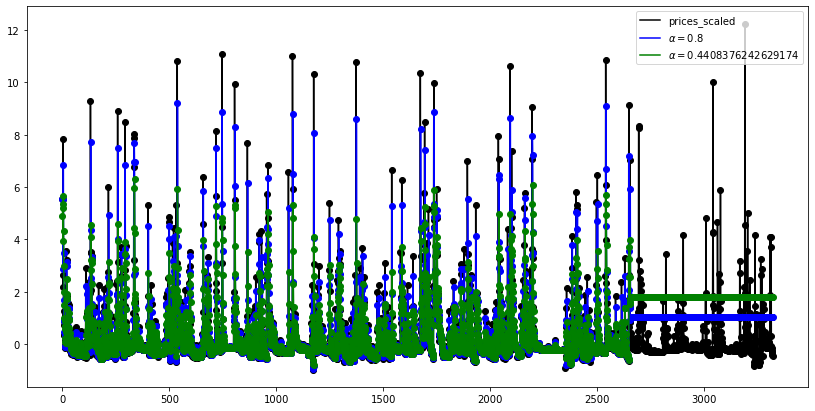

In [91]:
ses(y_train.append(y_test), y_train, y_test,0.8,predict_date=len(y_test))


### additive/multiplicative smoothing - Holt-Winters' Seasonal Method

In [99]:
from statsmodels.tsa.api import ExponentialSmoothing

def holt_win_sea(y,y_to_train,y_to_test,seasonal_type,seasonal_period,predict_date):
    
    y.plot(marker='o', color='black', legend=True, figsize=(14, 7))
    
    if seasonal_type == 'additive':
        fit1 = ExponentialSmoothing(y_to_train, seasonal_periods = seasonal_period, trend='add', seasonal='add').fit()
        fcast1 = fit1.forecast(predict_date).rename('Additive')
        mse1 = ((fcast1 - y_to_test) ** 2).mean()
        print('The Root Mean Squared Error of additive trend, additive seasonal of '+ 
              'period season_length={} and a Box-Cox transformation {}'.format(seasonal_period,round(np.sqrt(mse1), 2)))
        
        fit2 = ExponentialSmoothing(y_to_train, seasonal_periods = seasonal_period, trend='add', seasonal='add', damped=True).fit()
        fcast2 = fit2.forecast(predict_date).rename('Additive+damped')
        mse2 = ((fcast2 - y_to_test) ** 2).mean()
        print('The Root Mean Squared Error of additive damped trend, additive seasonal of '+ 
              'period season_length={} and a Box-Cox transformation {}'.format(seasonal_period,round(np.sqrt(mse2), 2)))
        
        fit1.fittedvalues.plot(style='--', color='red')
        fcast1.plot(style='--', marker='o', color='red', legend=True)
        fit2.fittedvalues.plot(style='--', color='green')
        fcast2.plot(style='--', marker='o', color='green', legend=True)
    
    elif seasonal_type == 'multiplicative':  
        fit3 = ExponentialSmoothing(y_to_train, seasonal_periods = seasonal_period, trend='add', seasonal='mul').fit()
        fcast3 = fit3.forecast(predict_date).rename('Multiplicative')
        mse3 = ((fcast3 - y_to_test) ** 2).mean()
        print('The Root Mean Squared Error of additive trend, multiplicative seasonal of '+ 
              'period season_length={} and a Box-Cox transformation {}'.format(seasonal_period,round(np.sqrt(mse3), 2)))
        
        fit4 = ExponentialSmoothing(y_to_train, seasonal_periods = seasonal_period, trend='add', seasonal='mul', damped=True).fit()
        fcast4 = fit4.forecast(predict_date).rename('Multiplicative+damped')
        mse4 = ((fcast3 - y_to_test) ** 2).mean()
        print('The Root Mean Squared Error of additive damped trend, multiplicative seasonal of '+ 
              'period season_length={} and a Box-Cox transformation {}'.format(seasonal_period,round(np.sqrt(mse4), 2)))
        
        fit3.fittedvalues.plot(style='--', color='red')
        fcast3.plot(style='--', marker='o', color='red', legend=True)
        fit4.fittedvalues.plot(style='--', color='green')
        fcast4.plot(style='--', marker='o', color='green', legend=True)
        
    else:
        print('Wrong Seasonal Type. Please choose between additive and multiplicative')

    plt.show()

The Root Mean Squared Error of additive trend, additive seasonal of period season_length=52 and a Box-Cox transformation 1.86
The Root Mean Squared Error of additive damped trend, additive seasonal of period season_length=52 and a Box-Cox transformation 2.16


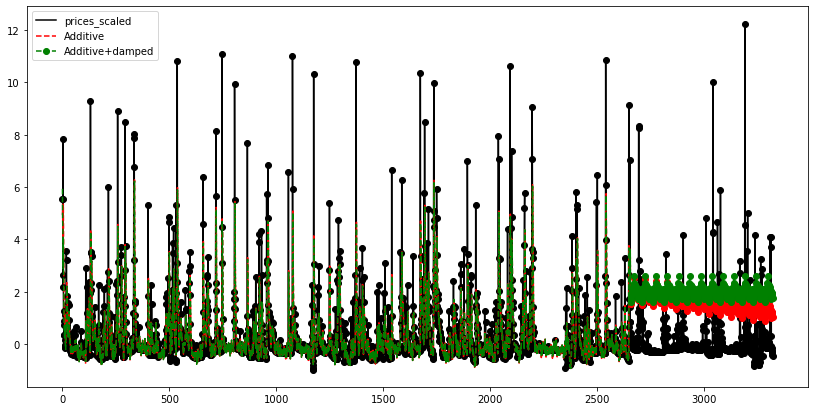

In [100]:
holt_win_sea(y_train.append(y_test), y_train, y_test,'additive',52, len(y_test))


### Gridsearch for ARIMA

In [126]:
# Source: https://towardsdatascience.com/an-end-to-end-project-on-time-series-analysis-and-forecasting-with-python-4835e6bf050b

for param in pdq:
    for param_seasonal in seasonal_pdq:
        try:
            mod = sm.tsa.statespace.SARIMAX(y_train.append(y_test),
                                            order=param,
                                            seasonal_order=param_seasonal,
                                            enforce_stationarity=False,
                                            enforce_invertibility=False)
            results = mod.fit()
            print('ARIMA{}x{}12 - AIC:{}'.format(param, param_seasonal, results.aic))
        except:
            continue


Why does this not print anything? sus